importing packages & files

In [126]:
# import packages, files

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

census_df = pd.read_excel('../Data/census_data.xls', sheet_name='est22ALL', skiprows=3, engine='xlrd')

graduation_df = pd.read_excel('../Data/graduation_rates.xlsx', sheet_name='Data')

library_df = pd.read_excel('../Data/library_data.xlsx', sheet_name='PLS_FY22_AE_pud22i')

create primary keys for join

In [127]:
# align dataframes for merging across counties
# using keys "state", "county"
# no trailing whitespace, all lowercase

# graduation file needs to have state extracted, words like "county" removed

graduation_df['STATE'] = graduation_df['COUNTY'].str.extract(r",\s*([A-Z]{2})$")
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*County,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Municipality,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough/.*", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Census( Area)?", "", regex=True)


for col in graduation_df.columns:
    if graduation_df[col].dtype == 'object': 
        graduation_df[col] = graduation_df[col].str.lower().str.strip()
        
# library file needs to be made lowercase

library_df.rename(columns={'STABR': 'STATE', 'CNTY': 'COUNTY'}, inplace=True)
library_df['STATE'] = library_df['STATE'].str.lower().str.strip()
library_df['COUNTY'] = library_df['COUNTY'].str.lower().str.strip()

# census file needs to have state extracted, words like "county" removed

census_df.rename(columns={'Postal Code': 'STATE', 'Name': 'COUNTY'}, inplace=True)
census_df['COUNTY'] = census_df['COUNTY'].str.replace(r"\s*(County|Borough|Municipality|Census( Area)?)", "", regex=True)

census_df['STATE'] = census_df['STATE'].str.lower().str.strip()
census_df['COUNTY'] = census_df['COUNTY'].str.lower().str.strip()

rename & select columns

In [128]:
# select and rename relevant columns before merging

graduation_df.columns = graduation_df.columns.astype(str)

print(graduation_df.columns)

graduation_df = graduation_df[['STATE', 'COUNTY', '2022-01-01 00:00:00']]
graduation_df.rename(columns={'2022-01-01 00:00:00': 'grad_rate'}, inplace=True)

library_df = library_df[['STATE', 'COUNTY', 'POPU_LSA', 'VISITS', 'REGBOR', 'LOCGVT', 'LCAP_REV', 'TOTPRO', 'TOTSTAFF', 'TOTCIR', 'CENTLIB', 'BRANLIB']]

# Identify the columns to transform
columns_to_lower = library_df.columns[2:]  # From 'POPU_LSA' onwards

# Convert these columns to lowercase
library_df.rename(columns={col: col.lower() for col in columns_to_lower}, inplace=True)

# drop blank columns

census_df = census_df[(census_df['90% CI Upper Bound.6'] != ".") & 
                      (census_df['90% CI Lower Bound.6'] != ".")]

# Ensure columns are cast to float before subtraction
census_df['90% CI Upper Bound.6'] = census_df['90% CI Upper Bound.6'].astype(float)
census_df['90% CI Lower Bound.6'] = census_df['90% CI Lower Bound.6'].astype(float)

# create variable "income_range"
census_df['income_range'] = census_df['90% CI Upper Bound.6'] - census_df['90% CI Lower Bound.6']

census_df = census_df[['STATE', 'COUNTY', 'Poverty Percent, Age 5-17 in Families', 'Median Household Income', 'income_range']]

census_df.rename(columns={'Poverty Percent, Age 5-17 in Families':'poverty_percent', 'Median Household Income':'med_income'}, inplace=True)

print('lib')
print(library_df)
print('census')
print(census_df)
print('grad')
print(graduation_df)

Index(['COUNTY', 'CODE', '2010-01-01 00:00:00', '2011-01-01 00:00:00',
       '2012-01-01 00:00:00', '2013-01-01 00:00:00', '2014-01-01 00:00:00',
       '2015-01-01 00:00:00', '2016-01-01 00:00:00', '2017-01-01 00:00:00',
       '2018-01-01 00:00:00', '2019-01-01 00:00:00', '2020-01-01 00:00:00',
       '2021-01-01 00:00:00', '2022-01-01 00:00:00', 'STATE'],
      dtype='object')
lib
     STATE             COUNTY  popu_lsa  visits  regbor   locgvt  lcap_rev  \
0       ak    kenai peninsula      2105    5127    1950        0         0   
1       ak          anchorage    291247  261807  123846  9181224         0   
2       ak             denali       177     421     138     6885         0   
3       ak             bethel      6325   12817    2062    89600         0   
4       ak  matanuska-susitna     10066   27063    2867   404502         0   
...    ...                ...       ...     ...     ...      ...       ...   
9243    wy           sublette      8723   96858    4525  1065115  

merge columns. left joined on graduation data

In [129]:
# First, left join graduation_df (left) with library_df (right)
merged_df = graduation_df.merge(library_df, on=['STATE', 'COUNTY'], how='left')

# Then, left join the result with census_df (right)
merged_df = merged_df.merge(census_df, on=['STATE', 'COUNTY'], how='left')

# Print the resulting DataFrame
print(merged_df)

# Select columns to convert (exclude 'STATE' and 'COUNTY')
columns_to_convert = merged_df.columns.difference(['STATE', 'COUNTY'])

# Convert selected columns to float
merged_df[columns_to_convert] = merged_df[columns_to_convert].astype(float)

# Verify the conversion
print(merged_df.dtypes)

# Count rows with null values
rows_with_nulls = merged_df.isnull().any(axis=1).sum()

# Count rows without null values
rows_without_nulls = (~merged_df.isnull().any(axis=1)).sum()

# Print the results
print(f"Number of rows with null values: {rows_with_nulls}")
print(f"Number of rows without null values: {rows_without_nulls}")

     STATE     COUNTY  grad_rate  popu_lsa    visits   regbor     locgvt  \
0       al    autauga       90.4   56145.0   62905.0  32024.0   525500.0   
1       al    baldwin       91.6  102040.0   10000.0   2316.0   115000.0   
2       al    baldwin       91.6   27719.0  102903.0  14589.0  1105517.0   
3       al    baldwin       91.6   23584.0  156951.0  19876.0   859000.0   
4       al    baldwin       91.6   21446.0  137258.0  16302.0   986737.0   
...    ...        ...        ...       ...       ...      ...        ...   
9636    pr  vega baja       76.7       NaN       NaN      NaN        NaN   
9637    pr    vieques       72.3       NaN       NaN      NaN        NaN   
9638    pr   villalba       78.9       NaN       NaN      NaN        NaN   
9639    pr    yabucoa       74.8       NaN       NaN      NaN        NaN   
9640    pr      yauco       79.0   42043.0      -1.0     -1.0       -1.0   

      lcap_rev  totpro  totstaff    totcir  centlib  branlib poverty_percent  \
0      

deal with null, negative values. 

THIS AREA MAY NEED ADJUSTMENTS FOR IMPUTATIONS

In [130]:
# deal with null columns, missing columns (imputation)
# may need more refined future approach

# Drop rows with null values
filtered_df = merged_df.dropna()

# Define the columns to check (exclude 'STATE' and 'COUNTY')
columns_to_check = filtered_df.columns.difference(['STATE', 'COUNTY'])

# Drop rows with null values in the selected columns
filtered_df = filtered_df.dropna(subset=columns_to_check)

# Drop rows with negative values in the selected columns
filtered_df = filtered_df[(filtered_df[columns_to_check] >= 0).all(axis=1)]

# Print the resulting DataFrame
print(f"Number of rows after filtering: {len(filtered_df)}")
print(filtered_df)

Number of rows after filtering: 8392
     STATE      COUNTY  grad_rate  popu_lsa    visits   regbor     locgvt  \
0       al     autauga       90.4   56145.0   62905.0  32024.0   525500.0   
1       al     baldwin       91.6  102040.0   10000.0   2316.0   115000.0   
2       al     baldwin       91.6   27719.0  102903.0  14589.0  1105517.0   
3       al     baldwin       91.6   23584.0  156951.0  19876.0   859000.0   
4       al     baldwin       91.6   21446.0  137258.0  16302.0   986737.0   
...    ...         ...        ...       ...       ...      ...        ...   
9555    wy  sweetwater       93.0   42158.0  222458.0  31288.0  3191699.0   
9556    wy       teton       96.0   23347.0  124903.0  17071.0  3699837.0   
9557    wy       uinta       94.4   20441.0   71067.0  11107.0   484087.0   
9558    wy    washakie       94.7    7658.0   44650.0   6850.0   298427.0   
9559    wy      weston       91.1    6809.0   25230.0   5056.0   319143.0   

      lcap_rev  totpro  totstaff    to

variables:
- STATE, COUNTY --> primary key
- grad_rate --> high school grad rate (%)
- popu_lsa --> population of library area (sum across all library systems in county? or is there overlap)
- visits --> num visits in year (sum across library systems in county)
- regbor --> registered users (sum across all library systems in county? problem is people can be registered in more than one library)
- locgvt --> local government revenue (sum across? needs more analysis based off imputation methods)
- lcap_rev --> local government capital revenue (sum across?)
- totpro --> total programs (sum across library systems)
- totstaff --> total staff (sum across library systems)
- totcir --> total circulation (sum across library systems in county)
- centlib --> num central libraries in system (sum across)
- branlib --> num bran libraries in systems (sum across)
- poverty_percent --> % in poverty in county (will be same across)
- med_income --> median household income (will be same across)
- income_range --> dif in 90% upper/lower household income in county (will be same across)




In [131]:
# aggregate columns according to above

# Define aggregation logic for each column
aggregation_logic = {
    'grad_rate': 'first',  # Average graduation rate
    'popu_lsa': 'sum',  # Total population (may need deduplication if overlap exists)
    'visits': 'sum',  # Total visits across systems
    'regbor': 'sum',  # Total registered borrowers (note possible duplicates)
    'locgvt': 'sum',  # Total local government revenue
    'lcap_rev': 'sum',  # Total local government capital revenue
    'totpro': 'sum',  # Total programs offered
    'totstaff': 'sum',  # Total staff across systems
    'totcir': 'sum',  # Total circulation
    'centlib': 'sum',  # Total number of central libraries
    'branlib': 'sum',  # Total number of branch libraries
    'poverty_percent': 'first',  # Same across rows, use first occurrence
    'med_income': 'first',  # Same across rows, use first occurrence
    'income_range': 'first'  # Same across rows, use first occurrence
}

# Group by STATE and COUNTY and apply aggregation logic
aggregated_df = filtered_df.groupby(['STATE', 'COUNTY'], as_index=False).agg(aggregation_logic)

# Print the resulting aggregated DataFrame
print(aggregated_df)


     STATE                COUNTY  grad_rate  popu_lsa    visits    regbor  \
0       ak        aleutians east       81.0      50.0    1196.0     136.0   
1       ak             anchorage       94.2  291247.0  261807.0  123846.0   
2       ak           bristol bay       95.0     844.0    7359.0     407.0   
3       ak                denali       96.7    1162.0    1642.0    1227.0   
4       ak  fairbanks north star       94.7   95655.0  203237.0   42522.0   
...    ...                   ...        ...       ...       ...       ...   
2538    wy            sweetwater       93.0   42158.0  222458.0   31288.0   
2539    wy                 teton       96.0   23347.0  124903.0   17071.0   
2540    wy                 uinta       94.4   20441.0   71067.0   11107.0   
2541    wy              washakie       94.7    7658.0   44650.0    6850.0   
2542    wy                weston       91.1    6809.0   25230.0    5056.0   

         locgvt   lcap_rev  totpro  totstaff    totcir  centlib  branlib  \

convert relevant metrics to per capita

In [132]:
# convert some columns to per capita

# Define the columns to convert to per capita
columns_to_convert = ['visits', 'regbor', 'locgvt', 'lcap_rev', 'totpro', 'totstaff', 'totcir']

# Convert to per capita by dividing each column by 'popu_lsa'
for col in columns_to_convert:
    aggregated_df[col + '_per_capita'] = aggregated_df[col] / aggregated_df['popu_lsa']

# Drop the original columns (optional)
aggregated_df.drop(columns=columns_to_convert, inplace=True)

aggregated_df.drop(columns=['popu_lsa'], inplace=True)

# Inspect the result
print(aggregated_df.head())

  STATE                COUNTY  grad_rate  centlib  branlib  poverty_percent  \
0    ak        aleutians east       81.0      1.0      0.0             13.5   
1    ak             anchorage       94.2      1.0      4.0             10.4   
2    ak           bristol bay       95.0      1.0      1.0             13.7   
3    ak                denali       96.7      2.0      0.0              9.7   
4    ak  fairbanks north star       94.7      1.0      1.0              8.0   

   med_income  income_range  visits_per_capita  regbor_per_capita  \
0     85852.0       20864.0          23.920000           2.720000   
1     99162.0        8116.0           0.898917           0.425227   
2     96382.0       24492.0           8.719194           0.482227   
3     90897.0       19790.0           1.413081           1.055938   
4     84166.0       15140.0           2.124688           0.444535   

   locgvt_per_capita  lcap_rev_per_capita  totpro_per_capita  \
0         338.000000             0.000000     

create correlation matrix

C:\Users\Chris\AppData\Local\Temp\ipykernel_5112\485770921.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = aggregated_df.corr()


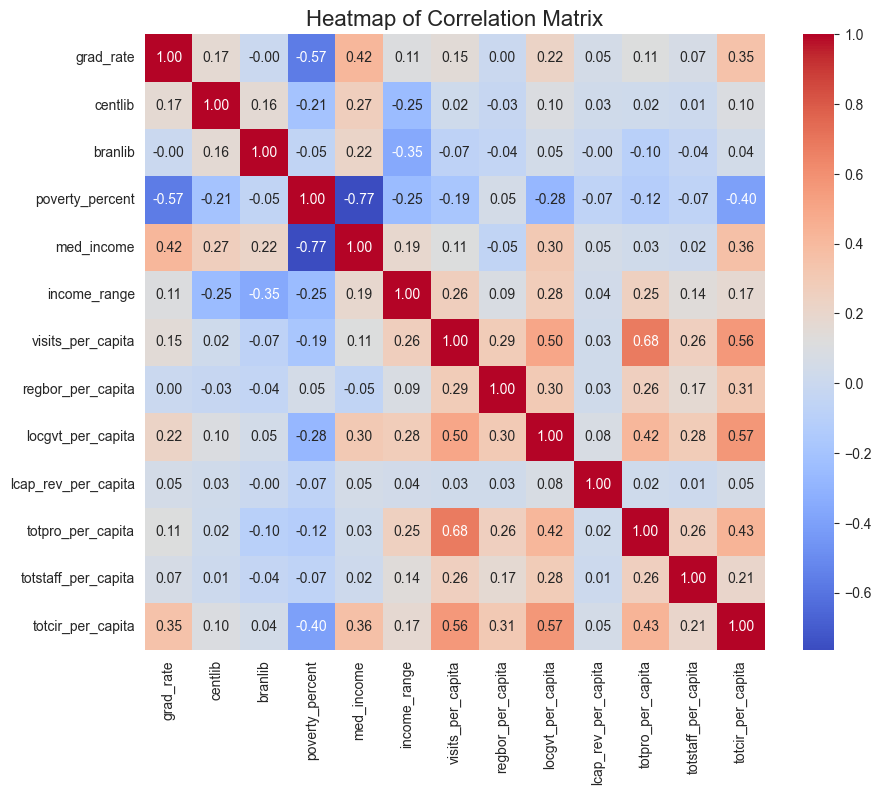

In [133]:
# Calculate the correlation matrix
corr_matrix = aggregated_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title("Heatmap of Correlation Matrix", fontsize=16)
plt.show()

scale data to prepare for regularized regression models

In [134]:
# Assuming aggregated_df is ready and cleaned

# Select features (X) and target variable (y)
X = aggregated_df.drop(columns=['STATE', 'COUNTY', 'grad_rate'])  # Drop non-numerical and target
y = aggregated_df['grad_rate']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [135]:
# Lasso regression with cross-validation
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Lasso performance
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)

lasso_train_error = mean_squared_error(y_train, lasso_train_pred)
lasso_test_error = mean_squared_error(y_test, lasso_test_pred)

print("Lasso Regression")
print(f"Best Alpha: {lasso.alpha_}")
print(f"Train Error (MSE): {lasso_train_error}")
print(f"Test Error (MSE): {lasso_test_error}")


Lasso Regression
Best Alpha: 0.09770099572992257
Train Error (MSE): 19.504770264596104
Test Error (MSE): 19.482282147509178


In [136]:
# Ridge regression with cross-validation
ridge = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=5)
ridge.fit(X_train, y_train)

# Ridge performance
ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)

ridge_train_error = mean_squared_error(y_train, ridge_train_pred)
ridge_test_error = mean_squared_error(y_test, ridge_test_pred)

print("\nRidge Regression")
print(f"Best Alpha: {ridge.alpha_}")
print(f"Train Error (MSE): {ridge_train_error}")
print(f"Test Error (MSE): {ridge_test_error}")


Ridge Regression
Best Alpha: 200.923300256505
Train Error (MSE): 19.520112382793783
Test Error (MSE): 19.36662870601778


observe weights and selected features of lasso

In [137]:
print("Lasso Selected Features:", np.array(X.columns)[lasso.coef_ != 0])
# Get the feature names from the original DataFrame (excluding target and non-numeric columns)
feature_names = X.columns

# Extract the coefficients from the trained Lasso model
lasso_coefficients = lasso.coef_

# Combine feature names and coefficients into a DataFrame for better readability
lasso_weights = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

# Sort by absolute coefficient value (optional, for interpretability)
lasso_weights = lasso_weights.reindex(lasso_weights['Coefficient'].abs().sort_values(ascending=False).index)

# Print the weights
print("Lasso Regression Coefficients:")
print(lasso_weights)

Lasso Selected Features: ['centlib' 'branlib' 'poverty_percent' 'income_range' 'visits_per_capita'
 'totcir_per_capita']
Lasso Regression Coefficients:
                Feature  Coefficient
2       poverty_percent    -2.843877
11    totcir_per_capita     0.639096
4          income_range    -0.181631
0               centlib     0.166711
1               branlib    -0.159137
5     visits_per_capita    -0.057397
3            med_income    -0.000000
6     regbor_per_capita    -0.000000
7     locgvt_per_capita     0.000000
8   lcap_rev_per_capita     0.000000
9     totpro_per_capita     0.000000
10  totstaff_per_capita     0.000000


distribution of outcomes. ensuring that they fall between 0-100

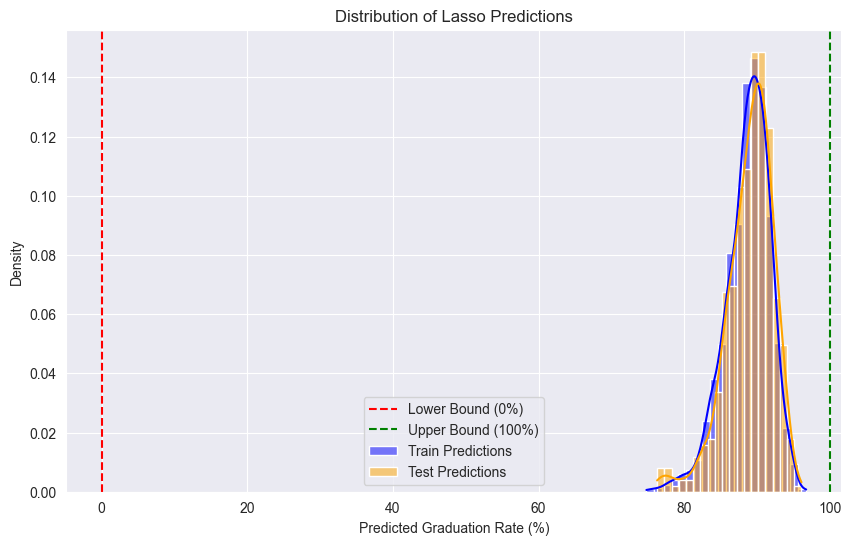

In [138]:
# Get predictions for train and test data
train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

# Plot distribution for train predictions
plt.figure(figsize=(10, 6))
sns.histplot(train_predictions, bins=20, kde=True, color='blue', label='Train Predictions', stat="density")
sns.histplot(test_predictions, bins=20, kde=True, color='orange', label='Test Predictions', stat="density")

# Add labels and title
plt.axvline(0, color='red', linestyle='--', label='Lower Bound (0%)')
plt.axvline(100, color='green', linestyle='--', label='Upper Bound (100%)')
plt.xlabel('Predicted Graduation Rate (%)')
plt.ylabel('Density')
plt.title('Distribution of Lasso Predictions')
plt.legend()
plt.show()